In [ ]:
# Install required packages
!pip install -q langchain langchain-community langchain-openai langchain-experimental langchain-neo4j
!pip install -q arxiv pymupdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.2/313.2 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.6/323.6 kB 9.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.
google-adk 1.

In [ ]:
# Print the installed versions
import subprocess

packages = [
    "langchain",
    "langchain-community",
    "langchain-openai",
    "langchain-experimental",
    "langchain-neo4j",
    "neo4j",
    "tiktoken",
    "arxiv",
    "pymupdf",
]

for pkg in packages:
    try:
        result = subprocess.run(["pip", "show", pkg], capture_output=True, text=True)
        version_line = [l for l in result.stdout.splitlines() if l.startswith("Version:")]
        version = version_line[0].split(":", 1)[1].strip() if version_line else "N/A"
        print(f"{pkg}=={version}")
    except Exception as e:
        print(f"{pkg}==N/A")

langchain==0.3.27
langchain-community==0.3.31
langchain-openai==0.3.35
langchain-experimental==0.3.4
langchain-neo4j==0.5.0
neo4j==5.28.2
tiktoken==0.12.0
arxiv==2.2.0
pymupdf==1.26.5


In [ ]:
import arxiv, os, pathlib, tempfile
from langchain_openai import ChatOpenAI
from langchain_community.document_loaders import PyMuPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain_neo4j import Neo4jGraph

In [ ]:
# OpenAI settings
os.environ["OPENAI_API_KEY"] = "YOUR OPENAI API KEY"

In [ ]:
# Neo4j settings
NEO4J_URI = "neo4j+s://<your-id>.databases.neo4j.io"
NEO4J_USERNAME = "neo4j"
NEO4J_PASSWORD = "********"

In [ ]:
ARXIV_ID = "2501.13956"

client = arxiv.Client()
search = arxiv.Search(id_list=[ARXIV_ID])
results = list(client.results(search))
assert results, f"No result for {ARXIV_ID}"
paper = results[0]

pdf_dir = pathlib.Path(tempfile.mkdtemp())
pdf_path = pdf_dir / f"{paper.get_short_id()}.pdf"
paper.download_pdf(filename=str(pdf_path))
print("Downloaded:", pdf_path)

docs = PyMuPDFLoader(str(pdf_path)).load()
print(f"Loaded {len(docs)} pages")

splitter = RecursiveCharacterTextSplitter(chunk_size=1800, chunk_overlap=250, separators=["\n\n", "\n", ". ", " ", ""])
chunks = splitter.split_documents(docs)
print(f"Loaded {len(chunks)} chunks")

Downloaded: /tmp/tmpr0txtqgu/2501.13956v1.pdf
Loaded 12 pages
Loaded 30 chunks


In [ ]:
from langchain_experimental.graph_transformers.llm import get_default_prompt

messages = get_default_prompt().messages
for msg in messages:
    print(f"[{msg.__class__.__name__}]")
    print(msg.prompt.template)
    print()

[SystemMessagePromptTemplate]
# Knowledge Graph Instructions for GPT-4
## 1. Overview
You are a top-tier algorithm designed for extracting information in structured formats to build a knowledge graph.
Try to capture as much information from the text as possible without sacrificing accuracy. Do not add any information that is not explicitly mentioned in the text.
- **Nodes** represent entities and concepts.
- The aim is to achieve simplicity and clarity in the knowledge graph, making it
accessible for a vast audience.
## 2. Labeling Nodes
- **Consistency**: Ensure you use available types for node labels.
Ensure you use basic or elementary types for node labels.
- For example, when you identify an entity representing a person, always label it as **'person'**. Avoid using more specific terms like 'mathematician' or 'scientist'.- **Node IDs**: Never utilize integers as node IDs. Node IDs should be names or human-readable identifiers found in the text.
- **Relationships** represent connecti

In [ ]:
# Settings of knowledge graph schema
ALLOWED_NODES = None
# ALLOWED_NODES = [
#     "Paper", "Author", "Institution", "Method", "Model", "Task", "Dataset",
#     "Metric", "Result", "Section", "Ablation"
# ]

# ALLOWED_RELATIONSHIPS = None
ALLOWED_RELATIONSHIPS = [
    # --- Core relationships ---
    "AUTHORED_BY",
    "PUBLISHED_BY",
    "DEVELOPED_BY",
    "ADDRESSES",
    "BASED_ON",
    "EXTENDS",
    "COMPARES_WITH",
    "OUTPERFORMS",
    "EVALUATES_ON",
    "ACHIEVES",
    "MEASURED_BY",
    "USES",
    "IMPLEMENTS",
    "INTEGRATES",
    "PART_OF",
    "REPRESENTS",
    # --- Extended relationships ---
    "POWERED_BY",
    "ENABLED_BY",
    "LIMITED_BY",
    "DIFFERS_FROM",
    "CONNECTS_TO",
    "TRANSFORMS",
    "EXTRACTS",
    "HOSTED_IN",
    "UPDATES",
    "RETURNS",
    # --- Others ---
    "RELATED_TO",
]

ADDITIONAL_INST = """
## Additional instructions
- If a relationship is unclear, please use RELATED_TO by default.
"""

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.1)
graph_llm = LLMGraphTransformer(
    llm=llm,
    allowed_nodes=ALLOWED_NODES,
    allowed_relationships=ALLOWED_RELATIONSHIPS,
    node_properties=True,
    relationship_properties=True,
    strict_mode=True,
    # prompt=None,
    additional_instructions=ADDITIONAL_INST,
    ignore_tool_usage=False
)

print("[2/5] Transforming text to graph...")
graph_docs = graph_llm.convert_to_graph_documents(chunks)
print(f"Extracted {len(graph_docs)} GraphDocuments")

[2/5] Transforming text to graph...
Extracted 30 GraphDocuments


In [ ]:
seen_nodes = set()
seen_ntypes = set()
seen_relationships = set()
seen_rtypes = set()

for graph_doc in graph_docs:
    for node in graph_doc.nodes:
        seen_nodes.add(node.id)
        seen_ntypes.add(node.type)

    for relationship in graph_doc.relationships:
        rtuple = (relationship.source.id, relationship.type, relationship.target.id)
        seen_relationships.add(rtuple)
        seen_rtypes.add(relationship.type)

print(f"Extracted #Nodes: {len(seen_nodes)}")
print(f"Extracted #Relationships: {len(seen_relationships)}")
print(f"Extracted #NodeTypes: {len(seen_ntypes)}")
print(f"  - {','.join(sorted(seen_ntypes))}")
print(f"Extracted #RelationshipTypes: {len(seen_rtypes)}")
print(f"  - {','.join(sorted(seen_rtypes))}")

Extracted #Nodes: 296
Extracted #Relationships: 268
Extracted #NodeTypes: 48
  - Agent,Benchmark,Cloud service,Component,Concept,Context,Database,Dataset,Date,Edge,Engine,Entity,Evaluation,Event,Fact,Field,Function,Knowledgegraph,Library,Llm agent,Location,Method,Methodology,Metric,Model,Node,Object type,Organization,Person,Process,Property,Publication,Question type,Relative timestamp,Repository,Service,Set,Subgraph,System,Task,Technique,Temporal range,Text string,Timeline,Timestamp,Tool,Type,Variable
Extracted #RelationshipTypes: 27
  - ACHIEVES,ADDRESSES,AUTHORED_BY,BASED_ON,COMPARES_WITH,CONNECTS_TO,DEVELOPED_BY,DIFFERS_FROM,ENABLED_BY,EVALUATES_ON,EXTENDS,EXTRACTS,HOSTED_IN,IMPLEMENTS,INTEGRATES,LIMITED_BY,MEASURED_BY,OUTPERFORMS,PART_OF,POWERED_BY,PUBLISHED_BY,RELATED_TO,REPRESENTS,RETURNS,TRANSFORMS,UPDATES,USES


In [ ]:
print("[3/5] Connecting to Neo4j AuraDB...")
graph = Neo4jGraph(url=NEO4J_URI, username=NEO4J_USERNAME, password=NEO4J_PASSWORD)

print("[4/5] Writing to AuraDB...")
graph.add_graph_documents(graph_docs, include_source=True)
print("[5/5] Done! Knowledge graph written to Neo4j")

[3/5] Connecting to Neo4j AuraDB...
[4/5] Writing to AuraDB...
[5/5] Done! Knowledge graph written to Neo4j


The knowledge graph is shown below:

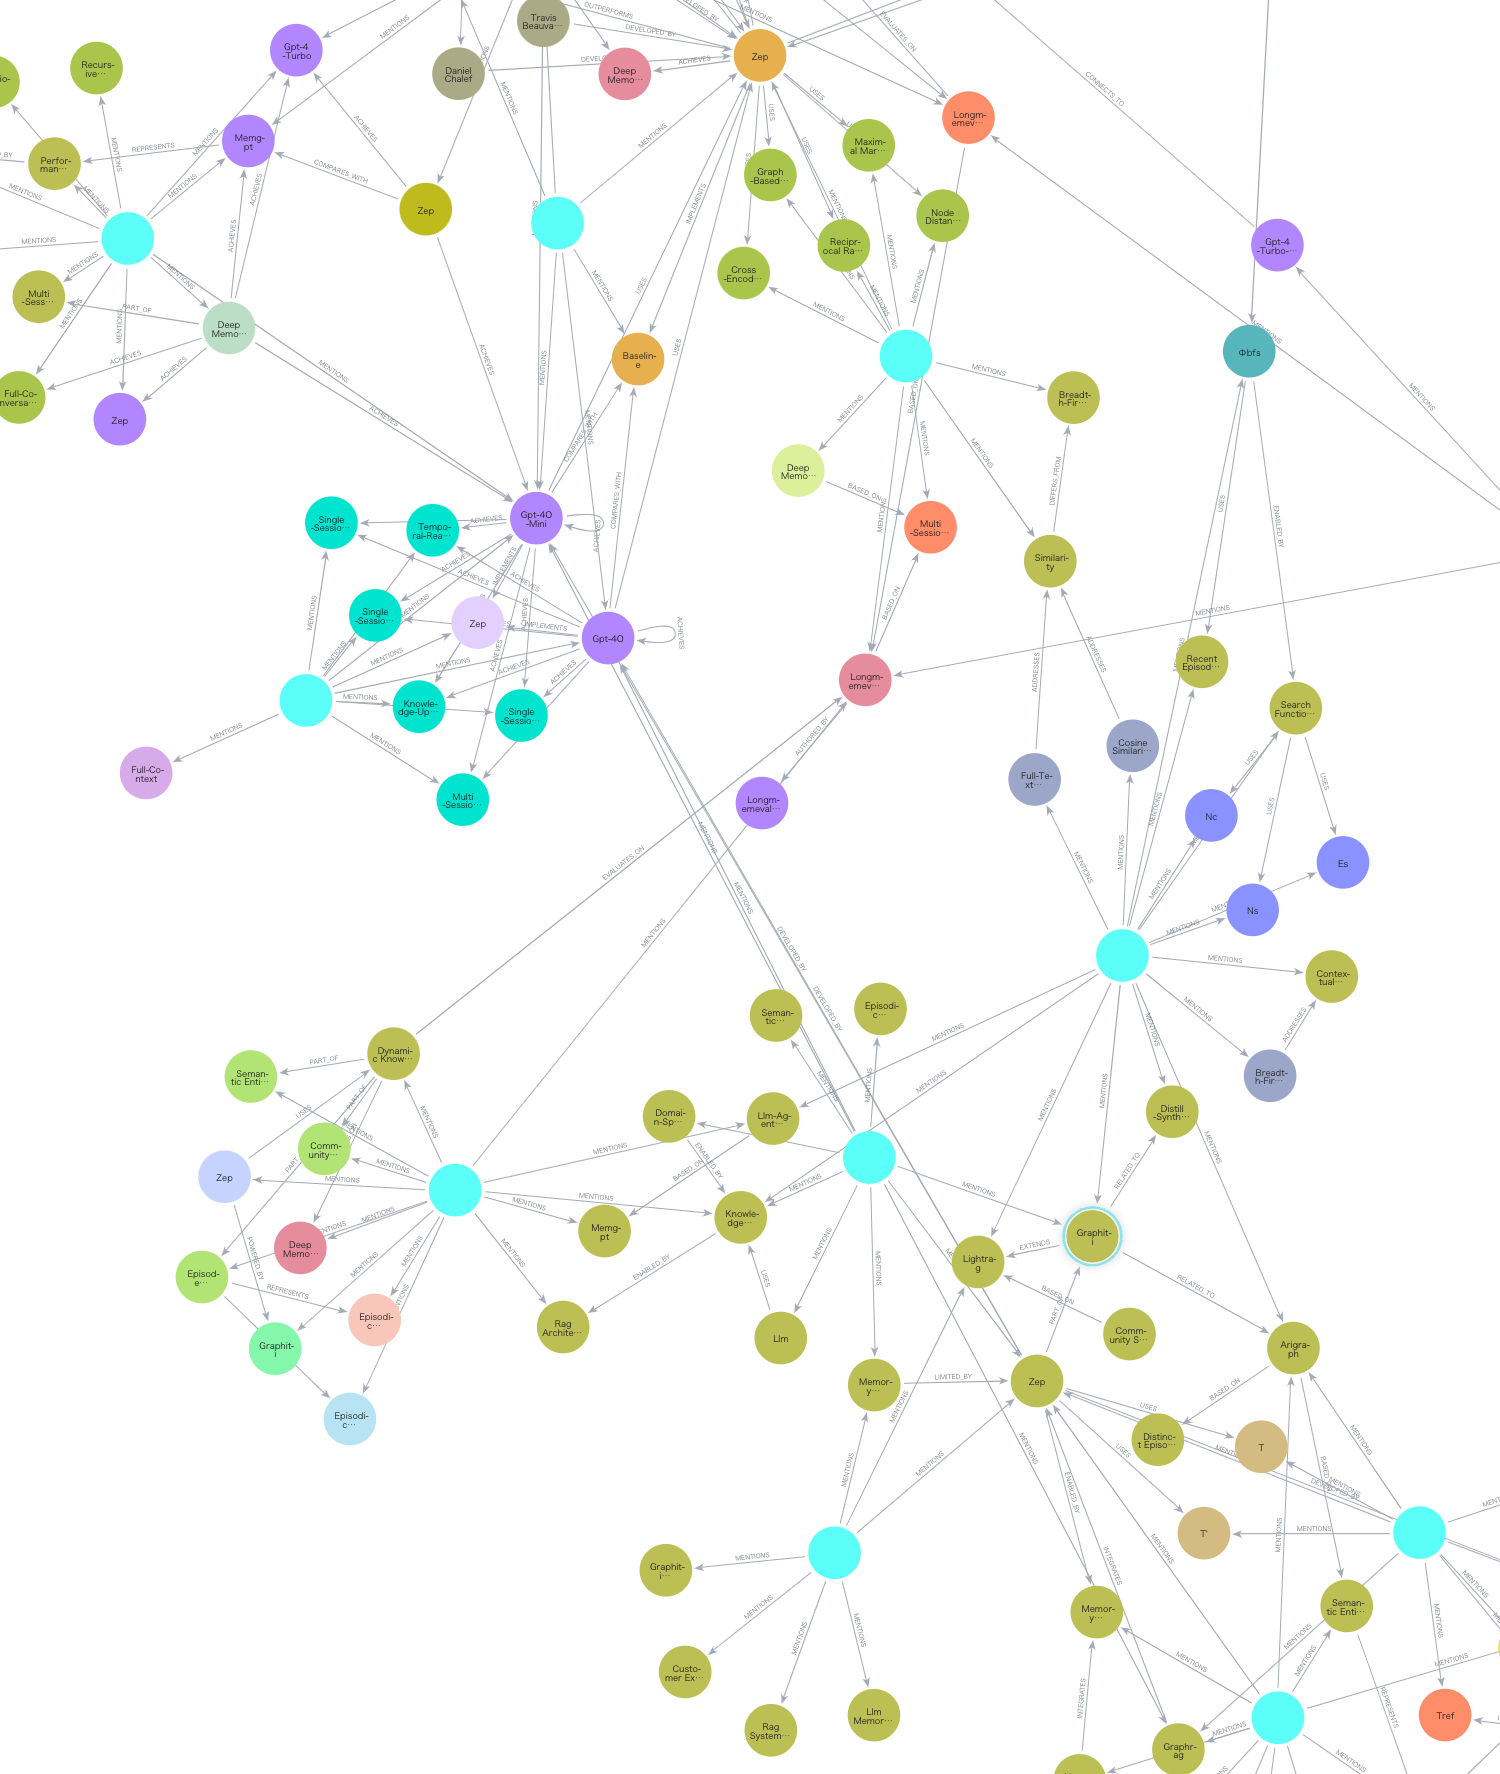